# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`01` 

* Catherine Prokhorov (62608) - `X` Hours worked on the project
* Guilherme Cepeda (62931) - `X` Hours worked on the project
* Jorge Aleluia (54549) - `X` Hours worked on the project 
* Rómulo Nogueira (56935) - `X` Hours worked on the project


The purpose of this Home Assignment is:

- Find similar items with Local Sensitivity Hashing
- Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**

### 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic


Students can use one of two datasets, that are not subsets of each other:
- `data_d3.pickle` - smaller set of structural features (2048)
- `data_d4.pickle` - much larger set of structural features (20736) **Note**: This dataset has been Zipped to fit into moodle. Students should unzip it before usage

Select **one** of the datasets and perform all analyses with it.

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



proteins_ids = docs

set_characteristics = words

In [1]:
### Your code here
import pickle
import sys
from scipy.sparse import dok_array, csr_array, csc_array, bsr_array, lil_array
import numpy as np

f = open("data_d4.pickle", "rb")

# Load the data
with open("data_d4.pickle", "rb") as f:
    data = pickle.load(f)

proteins_ids = list(data.keys())
set_characteristics = list(data.values())
max_characteristics = max([max(x) for x in set_characteristics])
len_characteristics = max_characteristics + 1

print("We have a total of {} human proteins".format(len(proteins_ids)))
print("And a total of {} specific structural characteristics".format(len_characteristics))
print("This would result in a matrix of size {}x{}".format(len(proteins_ids), len_characteristics))

def make_sparse_matrix(set_characteristics: list[set], proteins_ids: list, len_characteristics: int):
    N = len(proteins_ids)
    M = len_characteristics

    S_Mat = dok_array((N, M), dtype=np.int8)
    for i in range(N):
        characteristics_idxs = list(set_characteristics[i])
        S_Mat[i, characteristics_idxs] = 1

    return S_Mat

dok_matrix = make_sparse_matrix(set_characteristics, proteins_ids, len_characteristics)
csr_matrix = csr_array(dok_matrix)

print("CSR matrix size (in MB): ", sys.getsizeof(csr_matrix.data)/(1024*1024))

We have a total of 19258 human proteins
And a total of 20736 specific structural characteristics
This would result in a matrix of size 19258x20736
CSR matrix size (in MB):  0.0001068115234375


### 2. Perform Local Sensitivity Hashing (LSH)

- examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
- Comment your results

**BONUS POINTS**: It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [2]:
### Add support functions here
import time

def MakeBucketsT(TDocs, perms, N, M, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i==M:                              #this is the case that the document is empty 
                    SIGS[list(L), r]=i                # Highly unlikely in a real data set  
                    L={}
                                                      # we have completed the signature for a given band, 
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N,M=Data.shape
    #transpose the data set
    DT=Data.T
    DataT=[set(np.where(DT[i]==1)[0]) for i in range(M)]
    P=B*R
    np.random.seed(3)
    #print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms=[np.random.permutation(M) for i in range(P)]
    buckets=MakeBucketsT(DataT, perms, N, M, B,R, NB)
    return buckets

In [3]:
### Add processing code here

B = 80
R = 8
s = 0.60
P = 1-(1-s**R)**B
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, P))
s = 0.70
P = 1-(1-s**R)**B
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, P))

res = LSHT(csr_matrix.toarray(), B, R)

The probability that documents share at least one band signature if they are 0.60 similar is:  0.7421
The probability that documents share at least one band signature if they are 0.70 similar is:  0.9913


In [4]:
for b, buck in res:
    if len(res[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", res[(b,buck)])

Band 0 suggests these similar docs: {1820, 31}
Band 0 suggests these similar docs: {130, 17318, 172, 2159, 12884, 1304, 6138}
Band 0 suggests these similar docs: {14304, 164}
Band 0 suggests these similar docs: {5706, 12595, 10580, 189}
Band 0 suggests these similar docs: {203, 1374}
Band 0 suggests these similar docs: {320, 701, 16713, 3581, 799}
Band 0 suggests these similar docs: {469, 5606}
Band 0 suggests these similar docs: {15002, 547}
Band 0 suggests these similar docs: {15497, 558}
Band 0 suggests these similar docs: {2881, 569, 1943}
Band 0 suggests these similar docs: {6088, 599}
Band 0 suggests these similar docs: {777, 2722}
Band 0 suggests these similar docs: {12128, 825}
Band 0 suggests these similar docs: {16824, 859}
Band 0 suggests these similar docs: {4610, 3299, 5683, 5335, 953, 13918}
Band 0 suggests these similar docs: {16672, 1275}
Band 0 suggests these similar docs: {1362, 11922}
Band 0 suggests these similar docs: {7931, 1381}
Band 0 suggests these similar docs

##### Your short analysis here

### 3. Do dimensionality reduction

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information

In [25]:
### Add support functions here
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Dimensionality reduction using PCA
X = csr_matrix.toarray() 
y = np.array(proteins_ids)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

pca = PCA(n_components=70)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Map protein IDs to integers
protein_id_to_int = {protein_id: idx for idx, protein_id in enumerate(np.unique(proteins_ids))}
y_train_int = np.array([protein_id_to_int[pid] for pid in y_train])
y_test_int = np.array([protein_id_to_int[pid] for pid in y_test])

PC0 - Variance explained:  0.0806 - Total Variance:  0.0806
PC1 - Variance explained:  0.0108 - Total Variance:  0.0913
PC2 - Variance explained:  0.0078 - Total Variance:  0.0991
PC3 - Variance explained:  0.0064 - Total Variance:  0.1056
PC4 - Variance explained:  0.0045 - Total Variance:  0.1101
PC5 - Variance explained:  0.0040 - Total Variance:  0.1141
PC6 - Variance explained:  0.0036 - Total Variance:  0.1177
PC7 - Variance explained:  0.0031 - Total Variance:  0.1208
PC8 - Variance explained:  0.0028 - Total Variance:  0.1236
PC9 - Variance explained:  0.0023 - Total Variance:  0.1259
PC10 - Variance explained:  0.0021 - Total Variance:  0.1280
PC11 - Variance explained:  0.0017 - Total Variance:  0.1298
PC12 - Variance explained:  0.0017 - Total Variance:  0.1315
PC13 - Variance explained:  0.0016 - Total Variance:  0.1331
PC14 - Variance explained:  0.0014 - Total Variance:  0.1345
PC15 - Variance explained:  0.0013 - Total Variance:  0.1358
PC16 - Variance explained:  0.0013

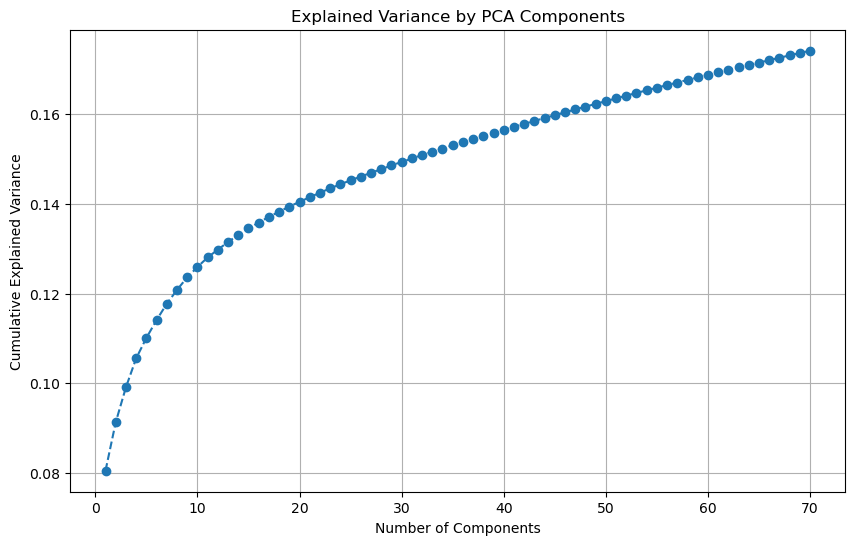

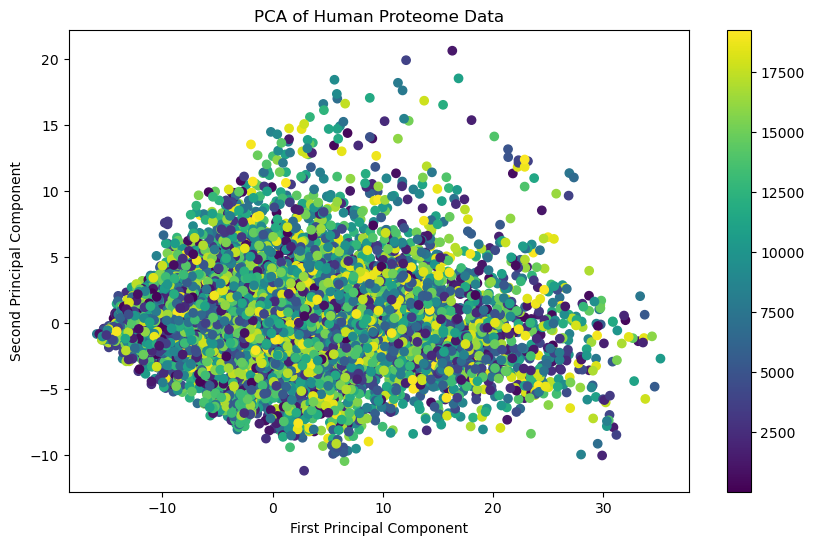

In [26]:
### Add processing code here

tve = 0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve += ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve))

print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, 71), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_int, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Human Proteome Data')
plt.colorbar(scatter)
plt.show()

##### Your short analysis here

Principal Component Analysis (PCA) was used to reduce the dimensionality of a dataset by examining the variance explained by each principal component. The dataset was divided into training and test sets, with 70 components specified. The study found that the first 70 principal components explained 17.41% of the variance. The largest eigenvalue was 1004.52, indicating the first principal component. The subsequent eigenvalues drop significantly, indicating that the first few components capture most of the variance. The eigenvalues of the first few components captured most of the variance. PCA successfully reduced the dataset's dimensionality, but the explained variance suggests that more than 70 components may be needed to retain most of the data's information.

### 3. Discuss your findings [to fill on your own]

- Comment your results above
- Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)
